In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("Step 1: Imports done")


Step 1: Imports done


In [18]:
data_dir = r"C:\Users\aparn\Downloads\face"
epochs = 2
batch_size = 4
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Step 2: Using device:", device)


Step 2: Using device: cpu


In [19]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

print("Step 3: Transforms ready")


Step 3: Transforms ready


In [20]:
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), train_transforms)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, "test"),  test_transforms)

print("Step 4: Dataset loaded")
print("Classes:", train_dataset.classes)


Step 4: Dataset loaded
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [21]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=0,
    pin_memory=False
)

print("Step 5: DataLoaders ready")


Step 5: DataLoaders ready


In [22]:
images, labels = next(iter(train_loader))
print("Step 6: First batch loaded:", images.shape)


Step 6: First batch loaded: torch.Size([4, 3, 224, 224])


In [23]:
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, len(train_dataset.classes))
model = model.to(device)

print("Step 7: Model ready")


Step 7: Model ready


C:\Users\aparn\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aparn\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
for param in model.features.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.001
)

print("Step 8: Starting training")


Step 8: Starting training


In [25]:
for epoch in range(epochs):
    model.train()
    print(f"\nEpoch {epoch+1}/{epochs} started")

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"  Batch {i}, Loss: {loss.item():.4f}")

print("\nTraining finished")



Epoch 1/2 started
  Batch 0, Loss: 1.9708
  Batch 10, Loss: 1.4638
  Batch 20, Loss: 2.2079
  Batch 30, Loss: 1.5138
  Batch 40, Loss: 1.6193
  Batch 50, Loss: 1.8317
  Batch 60, Loss: 1.9369
  Batch 70, Loss: 2.1445
  Batch 80, Loss: 1.8085
  Batch 90, Loss: 1.4207
  Batch 100, Loss: 1.6797
  Batch 110, Loss: 1.9620
  Batch 120, Loss: 2.1492
  Batch 130, Loss: 2.2310
  Batch 140, Loss: 1.4921
  Batch 150, Loss: 1.6980
  Batch 160, Loss: 2.1172
  Batch 170, Loss: 1.2814
  Batch 180, Loss: 1.8197
  Batch 190, Loss: 2.2971
  Batch 200, Loss: 2.1362
  Batch 210, Loss: 1.3274
  Batch 220, Loss: 2.3148
  Batch 230, Loss: 1.8329
  Batch 240, Loss: 2.3973
  Batch 250, Loss: 1.5096
  Batch 260, Loss: 1.4888
  Batch 270, Loss: 1.5245
  Batch 280, Loss: 1.9623
  Batch 290, Loss: 2.0395
  Batch 300, Loss: 2.4147
  Batch 310, Loss: 2.4232
  Batch 320, Loss: 1.6990
  Batch 330, Loss: 1.7291
  Batch 340, Loss: 1.4530
  Batch 350, Loss: 1.9012
  Batch 360, Loss: 2.5017
  Batch 370, Loss: 1.8208
  Ba

In [26]:
y_true, y_pred = [], []
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        preds = model(images.to(device)).argmax(1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))



Classification Report:

              precision    recall  f1-score   support

       angry       0.34      0.12      0.18       958
     disgust       0.24      0.09      0.13       111
        fear       0.30      0.10      0.15      1024
       happy       0.44      0.76      0.56      1774
     neutral       0.48      0.20      0.29      1233
         sad       0.33      0.43      0.37      1247
    surprise       0.47      0.68      0.55       831

    accuracy                           0.41      7178
   macro avg       0.37      0.34      0.32      7178
weighted avg       0.39      0.41      0.36      7178



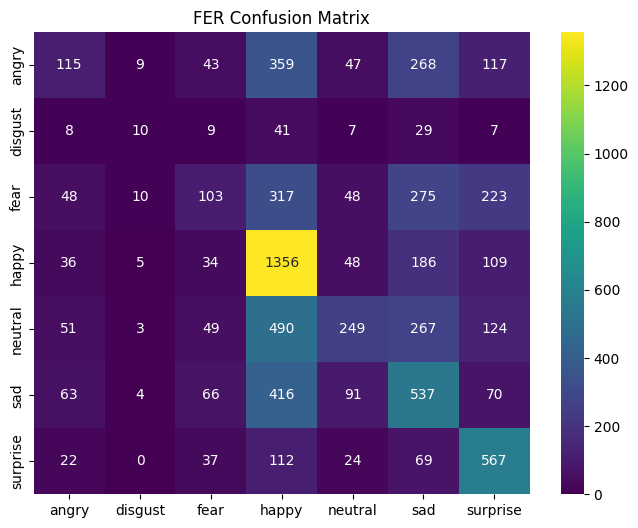

In [27]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title("FER Confusion Matrix")
plt.show()
